In [1]:
import pandas as pd
import altair as alt
import umap
from semvecpy.vectors import semvec_utils as semvec

%matplotlib inline
alt.renderers.enable('notebook')

import imp
esp_ddi_util = imp.load_source('esp_ddi_util', 'esp_ddi_util.py')

/home/haalbu/anaconda3/envs/test_2019-08-28/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/haalbu/anaconda3/envs/test_2019-08-28/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
!conda list | grep umap
!conda list | grep scikit-learn
!conda list | grep altair
!conda list | grep vega
!conda list | grep pandas
!conda list | grep notebook
!conda list | grep semvecpy

umap-learn                0.3.9                    py37_0    conda-forge
scikit-learn              0.19.1           py37hedc7406_0  
altair                    3.1.0                    py37_0    conda-forge
vega                      2.4.0                    py37_0    conda-forge
pandas                    0.24.2           py37he6710b0_0  
notebook                  5.7.8                    py37_0  
semvecpy                  0.1.2              pyh39e3cac_1    conda-forge


# Load data
For this notebook we will need the following data:
* **Training and test data**. To make our results directly comparable, we use the train/test splits produced by our Decagon run.
* **Mappings of drug and side effect IDs to their names**. Using names instead of IDs makes interpretation of the trained representations more convenient. While the side effect names come with the _bio-decagon_ data sets, the drug IDs had to be resolved separately using [version 2 of the STITCH ID database](http://stitch2.embl.de/). For convenience, files with the mappings are included in the repository. 

## Load names

In [3]:
drug_names_df = pd.read_csv("drug_names.csv", header=None)
drug_names_df.columns = ["drug", "drug_name"]
# rename drugs to conform to ESP subject/object convention
drug_names_df.drug_name = drug_names_df.drug_name.apply(
    lambda x: x.replace(" ", "_").lower())
drug_names_df.head()

,drug,drug_name
0,CID000000085,carnitine
1,CID000000119,gaba
2,CID000000143,leucovorin
3,CID000000158,pge2
4,CID000000159,prostacyclin


In [4]:
# create dictionary for later drug lookup
drug_names = drug_names_df.set_index('drug').to_dict()['drug_name']

side_effect_names_df = pd.read_csv(
    "side_effect_names.tsv", sep='\t', header=None)
side_effect_names_df.columns = ["side_effect", "side_effect_name"]

# rename side effects to conform to ESP predicate convention
side_effect_names_df.side_effect_name = side_effect_names_df.side_effect_name.apply(
    lambda x: x.replace(" ", "_").upper())
side_effect_names_df.head()

,side_effect,side_effect_name
0,C0151714,HYPERMAGNESEMIA
1,C0035344,RETINOPATHY_OF_PREMATURITY
2,C0004144,ATELECTASIS
3,C0002063,ALKALOSIS
4,C0004604,BACK_ACHE


In [5]:
side_effect_names = side_effect_names_df.set_index(
    "side_effect").to_dict()["side_effect_name"]

# examples
drug_names['CID000000853'], side_effect_names['C0035344']

('thyroxine', 'RETINOPATHY_OF_PREMATURITY')

## Load data test/train splits
The provided data sets were output by our own version of the Decagon code, available in the companion repository at https://github.com/hannahburkhardt/decagon. They are available for download from our zenodo repository at [TBD]. Predictions produced by this Decagon run are also available there.

The zenodo repository also contains a set of trained vector binaries produced by ESP, as well as a jar of the version of the semanticvector library used in this project. You may also download the source code from https://github.com/semanticvectors/semanticvectors and build semanticvectors yourself.

In [6]:
import os
if not os.path.exists("esp_ddi_zenodo.tar.gz"):
    !cd ..; wget https://zenodo.org/record/3333834/files/esp_ddi_zenodo.tar.gz
    # if wget is not installed, use the following command instead
    #!curl -o esp_ddi_zenodo.tar.gz https://zenodo.org/record/3333834/files/esp_ddi_zenodo.tar.gz
    !cd ..; tar -xzvf esp_ddi_zenodo.tar.gz

--2019-08-29 10:01:04--  https://zenodo.org/record/3333834/files/esp_ddi_zenodo.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.65.20
Connecting to zenodo.org (zenodo.org)|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188659542 (180M) [application/octet-stream]
Saving to: ‘esp_ddi_zenodo.tar.gz.1’

esp_ddi_zenodo.tar. 100%[===================>] 179.92M  17.1MB/s    in 11s     

2019-08-29 10:01:16 (15.8 MB/s) - ‘esp_ddi_zenodo.tar.gz.1’ saved [188659542/188659542]

zenodo/
zenodo/semanticvectors-5.9.jar
zenodo/decagon_split_train_drug_protein.tsv
zenodo/esp_vectors_16k_8cycles/
zenodo/decagon_scores_8_epochs.txt
zenodo/decagon_split_test_ddi_pos.tsv
zenodo/decagon_split_train_ddi.tsv
zenodo/decagon_split_test_ddi_neg.tsv
zenodo/decagon_split_val_ddi_pos.tsv
zenodo/decagon_split_train_ppi.tsv
zenodo/decagon_split_val_ddi_neg.tsv
zenodo/esp_vectors_16k_8cycles/elementalvectors.bin
zenodo/esp_vectors_16k_8cycles/predicatevectors.bin
zenodo/esp

In [7]:
file_location = "../zenodo/"

# Training data
train_ddi = pd.read_csv(
    file_location + 'decagon_split_train_ddi.tsv', sep="\t", header=None)
train_ppi = pd.read_csv(
    file_location + 'decagon_split_train_ppi.tsv', sep="\t", header=None)
train_drug_protein = pd.read_csv(
    file_location + 'decagon_split_train_drug_protein.tsv', sep="\t", header=None)

# Test data
test_ddi_pos = pd.read_csv(
    file_location + 'decagon_split_test_ddi_pos.tsv', sep="\t", header=None)
test_ddi_neg = pd.read_csv(
    file_location + 'decagon_split_test_ddi_neg.tsv', sep="\t", header=None)

# Validation data
val_ddi_pos = pd.read_csv(
    file_location + 'decagon_split_val_ddi_pos.tsv', sep="\t", header=None)

val_ddi_neg = pd.read_csv(
    file_location + 'decagon_split_val_ddi_neg.tsv', sep="\t", header=None)


In [8]:
train_drug_protein.sample(5)

,0,1,2
324,CID000004946,TARGETS,8811
2244,CID000005656,TARGETS,340024
7607,CID000002726,TARGETS,2850
26061,2844,TARGETS-2,CID000002476
26150,623,TARGETS-2,CID000002477


In [9]:
print(len(train_ddi))
train_ddi.sample(5)

7323790


,0,1,2
6339438,CID000005002,C0017181-2,CID000002656
3778382,CID000003467,C0235896-2,CID000003405
3023758,CID000004927,C0002962,CID000060865
6351369,CID000005358,C1510472-2,CID000004205
124742,CID000004259,C0019080,CID000083786


In [10]:
train_ppi.sample(5)

,0,1,2
901802,5031,INTERACTS_WITH,2915
335763,84549,INTERACTS_WITH,51426
2224578,9989,INTERACTS_WITH-2,5504
2195084,8139,INTERACTS_WITH-2,84668
1649424,90007,INTERACTS_WITH-2,1647


## Prep data

### Resolve IDs to names
For readability, resolve drug and side effect IDs to names. No need to resolve protein IDs.

In [11]:
resolve_drug_id = lambda drug_id: drug_names[drug_id] if drug_id in drug_names.keys() else drug_id
resolve_side_effect_id = lambda side_effect_id: side_effect_names[side_effect_id[:-2]]+"-2" if side_effect_id[-2:]=="-2" else side_effect_names[side_effect_id]

def resolve_names_ddi_df(df):
    df['subject'] = df[0].apply(resolve_drug_id)
    df['predicate'] = df[1].apply(resolve_side_effect_id)
    df['object'] = df[2].apply(resolve_drug_id)

def resolve_names_drug_protein_df(df):
    df['subject'] = df[0].apply(resolve_drug_id)
    df['predicate'] = df[1]
    df['object'] = df[2]

def resolve_names_protein_protein_df(df):
    df['subject'] = df[0]
    df['predicate'] = df[1]
    df['object'] = df[2]

In [12]:
for df in [train_ddi, test_ddi_pos, test_ddi_neg, val_ddi_pos, val_ddi_neg]:
    resolve_names_ddi_df(df)

resolve_names_drug_protein_df(train_drug_protein)

resolve_names_protein_protein_df(train_ppi)

In [13]:
train_ddi.sample(5)

,0,1,2,subject,predicate,object
6567018,CID000004173,C0042487-2,CID000003324,metronidazole,PHLEBOTHROMBOSIS-2,famciclovir
1011573,CID000004112,C0009806,CID000005656,methotrexate,CONSTIPATED,venlafaxine
3941312,CID000003440,C0020598-2,CID000002244,furosemide,BLOOD_CALCIUM_DECREASED-2,aspirin
4931251,CID000005090,C0043096-2,CID000001302,rofecoxib,LOSS_OF_WEIGHT-2,naproxen
5952147,CID000003883,C0152128-2,CID000003003,lansoprazole,DRUG_WITHDRAWAL-2,dexamethasone


Note that the dataset includes a second entry for each predicate with a "-2" suffix. These are created during the Decagon protocol by inverting triples. See the paper for further details.

In [14]:
train_ppi.sample(5)

,0,1,2,subject,predicate,object
1763835,5362,INTERACTS_WITH-2,25937,5362,INTERACTS_WITH-2,25937
1769409,5080,INTERACTS_WITH-2,8615,5080,INTERACTS_WITH-2,8615
1203623,55142,INTERACTS_WITH-2,85302,55142,INTERACTS_WITH-2,85302
1667478,9352,INTERACTS_WITH-2,2318,9352,INTERACTS_WITH-2,2318
1447103,9937,INTERACTS_WITH-2,22909,9937,INTERACTS_WITH-2,22909


In [15]:
train_drug_protein.sample(5)

,0,1,2,subject,predicate,object
22825,27347,TARGETS-2,CID005329102,27347,TARGETS-2,CID005329102
14277,CID000002266,TARGETS,51582,azelaic_acid,TARGETS,51582
2591,CID000000271,TARGETS,758,calcium,TARGETS,758
24718,1814,TARGETS-2,CID000125017,1814,TARGETS-2,CID000125017
24406,10887,TARGETS-2,CID000002160,10887,TARGETS-2,CID000002160


### Create files with training and test data
ESP accepts input files with tab separated subject-predicate-object triples. Here, we write the training data to the _outputs_ directory in this format.

In [16]:
!mkdir -p ../outputs/

In [17]:
file_location = "../outputs/" 

# All three types of data are used for training
train_ddi.append(train_ppi).append(train_drug_protein)[
    ['subject', 'predicate', 'object']].to_csv(path_or_buf=file_location+"training_examples.tsv", sep='\t', index=False, header=False)

# Use only the ddi data for testing sets
all_test_pos = test_ddi_pos[['subject', 'predicate', 'object']]
# remove reversed side effects for testing
all_test_pos = all_test_pos[~all_test_pos.predicate.str.contains("-2")]
all_test_pos.to_csv(path_or_buf=file_location +
                    "positive_examples.tsv", sep='\t', index=False, header=False)

all_test_neg = test_ddi_neg[['subject', 'predicate', 'object']]
# remove reversed side effects for testing
all_test_neg = all_test_neg[~all_test_neg.predicate.str.contains("-2")]
all_test_neg.to_csv(path_or_buf=file_location +
                    "negative_examples.tsv", sep='\t', index=False, header=False)

In [18]:
len(all_test_pos.predicate.unique())

963

### Create files with evaluation strings
For testing, we determine the similarity between the representation of the drug pair, `S(drug1)*E(drug2)`, and the representation of the side effect, `P(side effect)`. Semanticvectors accepts a file with a list of these, one per line.

In [19]:
make_string = lambda row: "S({})*E({})|P({})".format(row.subject, row.object, row.predicate)

positive_test_strings = all_test_pos.apply(make_string, axis=1)
positive_test_strings.to_csv(
    path=file_location+"positive_examples.csv", index=False, header=False)

negative_test_strings = all_test_neg.apply(make_string, axis=1)
negative_test_strings.to_csv(
    path=file_location+"negative_examples.csv", index=False, header=False)

/home/haalbu/anaconda3/envs/test_2019-08-28/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'path' will be renamed to 'path_or_buf'.
  """
/home/haalbu/anaconda3/envs/test_2019-08-28/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'path' will be renamed to 'path_or_buf'.
  if __name__ == '__main__':


# Train the model
Create the index and train the ESP model with 1024 dimensions for 4 training cycles. This will take a while (depending on hardware, about 1 hour).
The paper used 16,000 dimensions with 8 cycles, which would take about 3.5 hours.

In [ ]:
%%bash 
cd ../outputs

# Use 2> /dev/null to silence stderr
java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.lucene.LuceneIndexFromTriples training_examples.tsv 2> /dev/null

java -cp ../zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.ESP -luceneindexpath predication_index -vectortype binary -dimension 1024 -trainingcycles 4 -mutablepredicatevectors -samplingthreshold .00001 -numthreads 60 2> /dev/null

# Evaluation

## Make predictions on test set
Next, we make predictions for each triple in the test set by determining the similarity of the bound representations for the 2 drugs with the representation for the side effect.

In [21]:
predicate_vectors = semvec.readfile('../outputs/predicatevectors.bin')
semantic_vectors = semvec.readfile('../outputs/semanticvectors.bin')
elemental_vectors = semvec.readfile('../outputs/elementalvectors.bin')

1024   BINARY
1024   BINARY
1024   BINARY


Scoring the testing examples with semvecpy (below) will take about 5 min.

In [22]:
positive_scores = semvec.compare_terms_batch(positive_test_strings,
    elemental_vectors=elemental_vectors, semantic_vectors=semantic_vectors, predicate_vectors=predicate_vectors)
negative_scores = semvec.compare_terms_batch(negative_test_strings,
    elemental_vectors=elemental_vectors, semantic_vectors=semantic_vectors, predicate_vectors=predicate_vectors)

## Performance
We evaluate performance of our model by determining the AUROC, AUPRC, and AP@50 for each individual side effect. Performance is then reported as the average performance across the 963 side effects. This allows a direct comparison to the Decagon model's performance, which is reported in this way. Note that this approach causes the average AUROC to be higher than the overall AUROC if some high-performance side effects have few examples or low-performance side effects have many examples.

Positive results mean score: 0.351
Negative results mean score: 0.145
Overall AUROC: 0.877
Overall AUPRC: 0.841
Overall AP50: 1.0

Average performance over 963 side effects:
       median   mean    std    sem    min    max
auroc   0.892  0.892  0.026  0.001  0.818  0.969
auprc   0.861  0.863  0.036  0.001  0.767  0.966
ap50    0.866  0.856  0.076  0.002  0.529  1.000


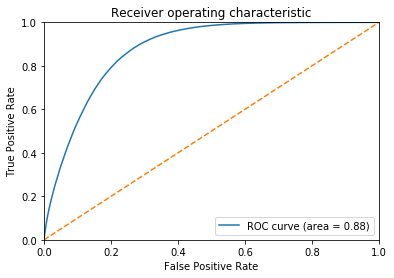

In [23]:
esp_aurocs_by_se = esp_ddi_util.get_aurocs_by_side_effect(all_test_pos, all_test_neg, positive_scores, negative_scores)

In [24]:
esp_aurocs_by_se.head()

,auroc,auprc,ap50,negative_examples,positive_examples
predicate_name,,,,,
ABDOMINAL_DISTENSION,0.861971,0.820511,0.903752,1236,1236
ABDOMINAL_HERNIA,0.929230,0.927796,1.000000,275,275
ABDOMINAL_PAIN,0.854855,0.813198,0.863393,2141,2141
ABDOMINAL_PAIN_UPPER,0.865146,0.826363,0.886086,1316,1316
ABNORMAL_CERVICAL_SMEAR,0.875689,0.823230,0.677668,66,66


Best and worst performing side effects for each measure:

In [25]:
for column in ['auroc', 'auprc', 'ap50']:
    print(column)
    print('min:', esp_aurocs_by_se[column].idxmin(), round(esp_aurocs_by_se[column].min(
    ), 3), 'max:', esp_aurocs_by_se[column].idxmax(), round(esp_aurocs_by_se[column].max(), 3))
    print()

auroc
min: PATENT_DUCTUS_ARTERIOSIS 0.818 max: MUMPS 0.969

auprc
min: CAESAREAN_SECTION 0.767 max: MUMPS 0.966

ap50
min: HIGH_BLOOD_PRESSURE 0.529 max: ABDOMINAL_HERNIA 1.0



### Performance distribution
Distribution of AUROCs: Does the model perform either well or poorly for most side effects, or are they normally distributed?

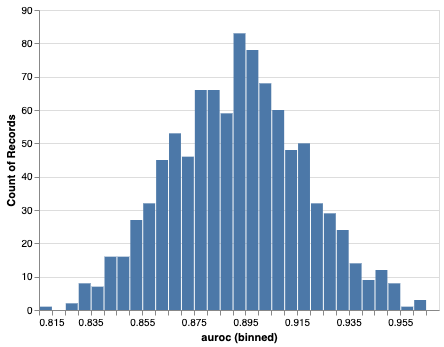

In [26]:
alt.Chart(esp_aurocs_by_se).mark_bar().encode(
    x=alt.X(
        'auroc', 
        bin=alt.Bin(maxbins=50)
    ), 
    y='count()', 
    tooltip=[
        alt.Tooltip('count()')
    ]
)

### Performance by side effect frequency
Does performance differ significantly depending on the number of examples we have for each side effect?

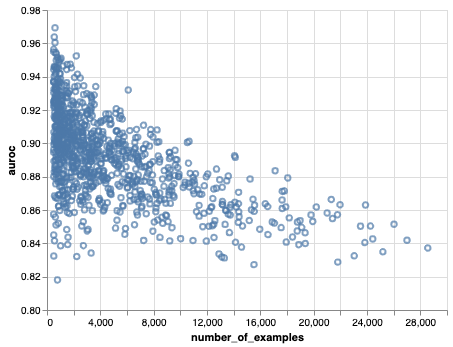

In [27]:
# the positive testing examples constitute 10% of the total number of samples in the dataset
alt.Chart(
    esp_aurocs_by_se.reset_index()
).mark_point().encode(
    alt.Y(
        'auroc',
        scale=alt.Scale(zero=False)
    ),
    x='number_of_examples:Q',
    tooltip=['predicate_name', 'number_of_examples:Q']
).transform_calculate(
    number_of_examples=alt.datum.positive_examples*10
)

This chart shows that performance is, on average, higher if there are fewer examples. This may be the case for a number of reasons, including that commonly reported side effects, such as nausea, may have a more noisy signal precisely because they are generally common and thus may not always be due to the particular combination of drugs. On the other hand, the model may be overfitting rare side effects, such as mumps, and performance may thus be inflated for these side effects.

### Score distribution by label
How are scores for positive and negative examples distributed?

In [28]:
pos_scores = pd.DataFrame(positive_scores, columns=['score'])
pos_scores['truth'] = 1
neg_scores = pd.DataFrame(negative_scores, columns=['score'])
neg_scores['truth'] = 0
scores = pos_scores.append(neg_scores)
scores.head()

,score,truth
0,0.208984,1
1,0.212891,1
2,0.197266,1
3,0.410156,1
4,0.017578,1


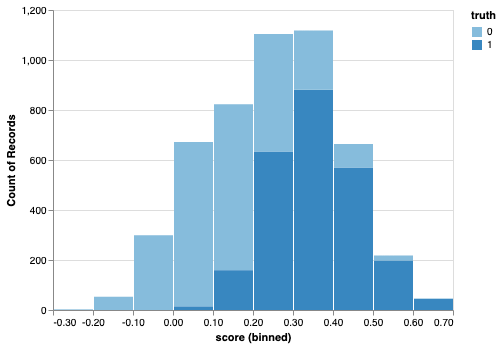

In [29]:
alt.Chart(scores.sample(5000)).mark_bar().encode(
    x=alt.X("score", bin=True), 
    y='count()', 
    color='truth:O'
)

## Dimensionality analysis

How low can we go in dimensionality and still preserve acceptable performance?

The code below will truncate the produced binary vector files to the given dimensionalities and evaluate the testing examples with the new vectors. This may take a while (depending on the number of dimensions, at least 25 min).

In [31]:
metrics = pd.DataFrame()
for dimensionality in [1024, 512, 256, 128, 64]:
    pv = (predicate_vectors[0], [bits[:dimensionality] for bits in predicate_vectors[1]])
    sv = (semantic_vectors[0], [bits[:dimensionality] for bits in semantic_vectors[1]])
    ev = (elemental_vectors[0], [bits[:dimensionality] for bits in elemental_vectors[1]])
    
    positive_scores = semvec.compare_terms_batch(positive_test_strings, 
                                                 elemental_vectors=ev, semantic_vectors=sv, predicate_vectors=pv)
    negative_scores = semvec.compare_terms_batch(negative_test_strings,
                                                elemental_vectors=ev, semantic_vectors=sv, predicate_vectors=pv)
    
    aurocs_by_se = esp_ddi_util.get_aurocs_by_side_effect(all_test_pos, all_test_neg, positive_scores, negative_scores, plot=False, verbose=False)

    metrics = metrics.append(pd.DataFrame(
        {"mean_auprc": aurocs_by_se.auprc.mean(), 
         "mean_auroc": aurocs_by_se.auroc.mean(), 
         "mean_ap50": aurocs_by_se.ap50.mean(),
         "auroc_min": aurocs_by_se.auroc.min(), 
         "auroc_max": aurocs_by_se.auroc.max(),
         "auprc_min": aurocs_by_se.auprc.min(), 
         "auprc_max": aurocs_by_se.auprc.max(),
         "ap50_min": aurocs_by_se.ap50.min(), 
         "ap50_max": aurocs_by_se.ap50.max(),
         },
        index=[dimensionality]))

metrics

,mean_auprc,mean_auroc,mean_ap50,auroc_min,auroc_max,auprc_min,auprc_max,ap50_min,ap50_max
1024,0.862751,0.891749,0.856250,0.818058,0.969306,0.766593,0.966228,0.529072,1.0
512,0.858331,0.887717,0.852559,0.805800,0.963611,0.764853,0.960210,0.581772,1.0
256,0.851229,0.879388,0.855335,0.790819,0.959184,0.754314,0.959835,0.586697,1.0
128,0.843915,0.869203,0.861395,0.774956,0.967222,0.729309,0.962006,0.585854,1.0
64,0.811537,0.839414,0.856124,0.737923,0.940000,0.673634,0.935506,0.479666,1.0


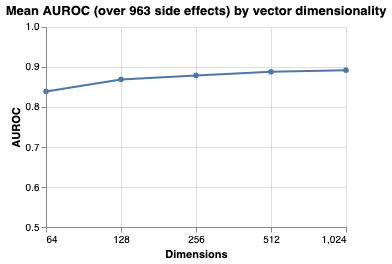

In [32]:
alt.Chart(
    metrics.reset_index().round(3),
    title='Mean AUROC (over 963 side effects) by vector dimensionality'
).mark_line(
    point=True
).encode(
    alt.X(
        'index:Q',
        title='Dimensions',
        scale=alt.Scale(type='log', base=2)
    ),
    alt.Y(
        'mean_auroc',
        title="AUROC",
        scale=alt.Scale(domain=[0.5, 1])
    ),
    tooltip=['mean_auroc', 'mean_auprc', 'mean_ap50']
).properties(width=300,height=200)

## UMAP
Next we use the Uniform Manifold Approximation and Projections (UMAP) library to create a 2-dimensional visualization of the vector space. In theory, similar concepts should result in similar embeddings, so we might expect the representations to cluster in some way, e.g. by side effect category.

In [33]:
predicate_vectors = semvec.readfile('../outputs/predicatevectors.bin')

# For the purposes of UMAP, remove reverse side effects and inverse relationships produced by ESP
df = pd.DataFrame(predicate_vectors[0])
indices = df[(~df[0].str.endswith("-2")) &
             (~df[0].str.endswith("-2-INV"))].index.tolist()
len(indices)

1024   BINARY


1930

In [34]:
predicate_vectors = ([predicate_vectors[0][i] for i in indices], [
                     predicate_vectors[1][i] for i in indices])
len(predicate_vectors), len(predicate_vectors[0])

(2, 1930)

Get side effect categories

In [35]:
%%bash
mkdir -p ../bio-decagon
cd ../bio-decagon/

wget http://snap.stanford.edu/decagon/bio-decagon-effectcategories.tar.gz
tar -zxvf bio-decagon-effectcategories.tar.gz

./._bio-decagon-effectcategories.csv
bio-decagon-effectcategories.csv


--2019-08-29 10:42:17--  http://snap.stanford.edu/decagon/bio-decagon-effectcategories.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7742 (7.6K) [application/x-gzip]
Saving to: ‘bio-decagon-effectcategories.tar.gz.1’

     0K .......                                               100%  373M=0s

2019-08-29 10:42:17 (373 MB/s) - ‘bio-decagon-effectcategories.tar.gz.1’ saved [7742/7742]



In [36]:
# Load side effect classes
file_location = "../bio-decagon/"
se_classes = pd.read_csv(file_location + "bio-decagon-effectcategories.csv")
se_classes.columns = ['side_effect', 'side_effect_name', 'disease_class']
se_classes.side_effect_name = se_classes.side_effect_name.apply(
    lambda x: x.replace(" ", "_").upper())
print(len(se_classes))
se_classes.head()

561


,side_effect,side_effect_name,disease_class
0,C0017152,GASTRIC_INFLAMMATION,gastrointestinal system disease
1,C0027858,NEUROMA,benign neoplasm
2,C0041466,TYPHOID,bacterial infectious disease
3,C0032807,POST_THROMBOTIC_SYNDROME,cardiovascular system disease
4,C0033860,PSORIASIS,integumentary system disease


In [37]:
# eliminate redundancy
se_classes.disease_class = se_classes.disease_class.apply(lambda x: 'hematopoietic system disease' if x=='hematopoietic system diseases' else x)

In [38]:
se_classes.head()

,side_effect,side_effect_name,disease_class
0,C0017152,GASTRIC_INFLAMMATION,gastrointestinal system disease
1,C0027858,NEUROMA,benign neoplasm
2,C0041466,TYPHOID,bacterial infectious disease
3,C0032807,POST_THROMBOTIC_SYNDROME,cardiovascular system disease
4,C0033860,PSORIASIS,integumentary system disease


In [39]:
se_classes = se_classes.set_index('side_effect_name').disease_class.to_dict()

Add side effect classes to our vector data

In [52]:
def get_class(side_effect): 
    name = side_effect
    # uncomment to include INVs
    #if name.endswith("-INV"):
    #    name = name[:-4]
    if name in se_classes:
        return se_classes[name]
    return 'other'

targets = pd.DataFrame(predicate_vectors[0])
targets['target'] = targets[0].apply(get_class)
targets = targets.set_index(0)
targets.head()

,target
0,
INSULIN_DEPENDENT_DIABETES_MELLITUS-INV,other
TELANGIECTASES-INV,other
PANCREATITIS_RELAPSING,other
INTERVERTEBRAL_DISC_DISORDER-INV,other
VESTIBULAR_DISORDER,nervous system disease


In [53]:
most_frequent_except_other = targets.target.value_counts().sort_values(ascending=False).reset_index().rename(columns={'target':'count', 'index':'class_name'}).class_name.tolist()[1:]
most_frequent_except_other

['nervous system disease',
 'cardiovascular system disease',
 'gastrointestinal system disease',
 'musculoskeletal system disease',
 'respiratory system disease',
 'integumentary system disease',
 'cancer',
 'urinary system disease',
 'hematopoietic system disease',
 'acquired metabolic disease',
 'endocrine system disease',
 'viral infectious disease',
 'reproductive system disease',
 'immune system disease',
 'fungal infectious disease',
 'benign neoplasm',
 'cognitive disorder',
 'thoracic disease',
 'bacterial infectious disease',
 'inherited metabolic disorder',
 'developmental disorder of mental health',
 'somatoform disorder',
 'irritable bowel syndrome',
 'sleep disorder',
 'sexual disorder',
 'substance-related disorder',
 'personality disorder',
 'pre-malignant neoplasm',
 'psoriatic arthritis']

In [54]:
import umap, matplotlib.pyplot as plt, numpy as np
points = umap.UMAP(random_state=42).fit_transform([bits.tolist() for bits in predicate_vectors[1]])

# Optionally t-SNE:
# from sklearn.manifold import TSNE
# points=TSNE(random_state=42).fit_transform(bit_df)

len(points)

1930

In [55]:
points_df = pd.DataFrame(points)
points_df['group'] = targets.reset_index().target
points_df['side_effect'] = targets.reset_index()[0]
points_df.columns=["x","y",'group','side_effect']
points_df.head()

,x,y,group,side_effect
0,10.095766,7.053929,other,INSULIN_DEPENDENT_DIABETES_MELLITUS-INV
1,8.059675,-1.534031,other,TELANGIECTASES-INV
2,-8.147509,-0.916823,other,PANCREATITIS_RELAPSING
3,9.011574,6.778860,other,INTERVERTEBRAL_DISC_DISORDER-INV
4,-8.686166,-0.313063,nervous system disease,VESTIBULAR_DISORDER


In [56]:
points_df.group.unique()

array(['other', 'nervous system disease', 'integumentary system disease',
       'hematopoietic system disease', 'gastrointestinal system disease',
       'somatoform disorder', 'respiratory system disease',
       'cardiovascular system disease', 'musculoskeletal system disease',
       'bacterial infectious disease', 'fungal infectious disease',
       'substance-related disorder', 'acquired metabolic disease',
       'thoracic disease', 'urinary system disease', 'cancer',
       'endocrine system disease', 'irritable bowel syndrome',
       'cognitive disorder', 'viral infectious disease',
       'reproductive system disease', 'immune system disease',
       'benign neoplasm', 'inherited metabolic disorder',
       'developmental disorder of mental health',
       'pre-malignant neoplasm', 'sexual disorder', 'sleep disorder',
       'personality disorder', 'psoriatic arthritis'], dtype=object)

There are too many classes to visualize nicely in a single graph. We might visualize the most frequent side effects (though the most frequent ones may contain more noise than others), or a random subset.

### Most frequent

In [57]:
groups = most_frequent_except_other[:6]
groups

['nervous system disease',
 'cardiovascular system disease',
 'gastrointestinal system disease',
 'musculoskeletal system disease',
 'respiratory system disease',
 'integumentary system disease']

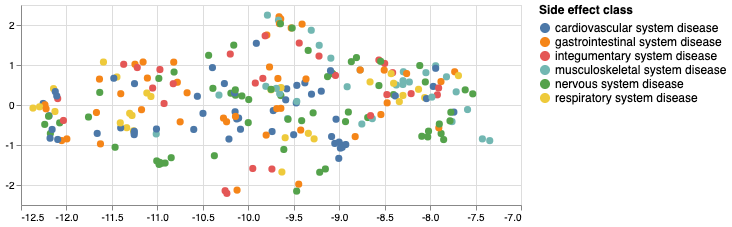

In [58]:
alt.Chart(data=points_df).mark_circle(size=50, opacity=1).encode(
    alt.X("x:Q", title="", scale=alt.Scale(zero=False)),
    alt.Y("y:Q", title="", scale=alt.Scale(zero=False)),
    alt.Color('group:N', title="Side effect class", scale=alt.Scale()),
    alt.Tooltip('side_effect:N')
).transform_filter(
    alt.FieldOneOfPredicate(field='group', oneOf=groups)
).properties(
    width=500, 
    height=200
).configure_legend(
    labelFontSize=12, 
    labelLimit=250, 
    titleFontSize=12
)

### Random

In [59]:
groups = pd.DataFrame(most_frequent_except_other).sample(8, random_state=42)[0].tolist()
groups

['pre-malignant neoplasm',
 'cognitive disorder',
 'reproductive system disease',
 'irritable bowel syndrome',
 'hematopoietic system disease',
 'acquired metabolic disease',
 'somatoform disorder',
 'nervous system disease']

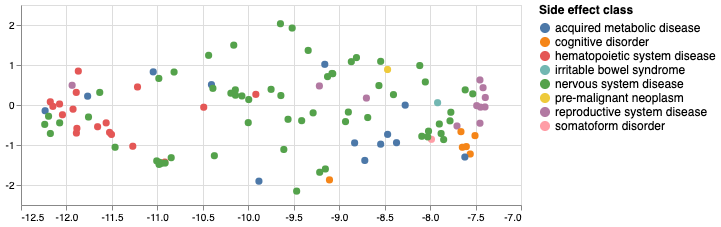

In [60]:
alt.Chart(data=points_df).mark_circle(size=50, opacity=1).encode(
    alt.X("x:Q", title="", scale=alt.Scale(zero=False)),
    alt.Y("y:Q", title=""),
    alt.Color('group:N', title="Side effect class", scale=alt.Scale()),
    alt.Tooltip('side_effect:N')
).transform_filter(
    alt.FieldOneOfPredicate(field='group', oneOf=groups)
).properties(
    width=500, 
    height=200
).configure_legend(
    labelFontSize=12, 
    labelLimit=250, 
    titleFontSize=12
)

### All

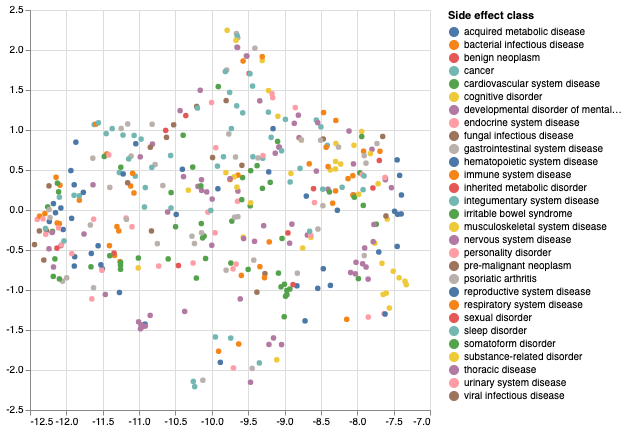

In [61]:
alt.Chart(data=points_df[points_df.group!='other']).mark_circle(opacity=1).encode(
    alt.X("x:Q",title=None,scale=alt.Scale(zero=False)),
    alt.Y("y:Q",title=None,scale=alt.Scale(zero=False)),
    alt.Color('group:N', title="Side effect class"),
    alt.Tooltip('side_effect:N')
).properties(width=400, height=400)

## Searching for familiar concepts
Another approach to investigation the learned vector space is to search for familiar concepts. Semanticvectors returns the top concepts in order of similarity to the query term.

In [62]:
predicate_vectors = semvec.readfile('../outputs/predicatevectors.bin')
semantic_vectors = semvec.readfile('../outputs/semanticvectors.bin')
elemental_vectors = semvec.readfile('../outputs/elementalvectors.bin')

1024   BINARY
1024   BINARY
1024   BINARY


In [63]:
semvec.search("KIDNEY_FAILURE", predicate_vectors, count=10)

[[1.0, 'KIDNEY_FAILURE'],
 [0.974609375, 'KIDNEY_FAILURE-2-INV'],
 [0.923828125, 'ACUTE_KIDNEY_FAILURE-2-INV'],
 [0.908203125, 'ACUTE_KIDNEY_FAILURE'],
 [0.87890625, 'HEPATIC_FAILURE'],
 [0.869140625, 'HEPATIC_FAILURE-2-INV'],
 [0.861328125, 'ANAEMIA-2-INV'],
 [0.857421875, 'CARDIAC_FAILURE-2-INV'],
 [0.857421875, 'BLEEDING-2-INV'],
 [0.857421875, 'ASPARTATE_AMINOTRANSFERASE_INCREASE']]

Note that ESP treats relationships as directional, and therefore creates separate predicates, suffixed with "-INV", to represent inverse relationships. Because the dataset extracted from Decagon also inverts triples (though before training rather than as part of training), we get side effects (predicates) suffixed "-2-INV" which are very nearly identical to the original predicates.

In [64]:
semvec.search("S(aspirin)*E(warfarin)", predicate_vectors, semantic_vectors=semantic_vectors, predicate_vectors=predicate_vectors, elemental_vectors=elemental_vectors, search_type='boundproduct', count=10)

[[0.361328125, 'FIBROSING_ALVEOLITIS'],
 [0.359375, 'PAROTITIS'],
 [0.359375, 'HAEMARTHROSIS'],
 [0.353515625, 'HAEMARTHROSIS-2-INV'],
 [0.3515625, 'NECK_MASS-2-INV'],
 [0.34765625, 'GOUTY_ARTHRITIS-2-INV'],
 [0.34375, 'PULMONARY_MASS-2-INV'],
 [0.341796875, 'PAROTITIS-2-INV'],
 [0.341796875, 'GOUTY_ARTHRITIS'],
 [0.341796875, 'SWOLLEN_SCROTUM-2-INV']]

# Decagon evaluation
The scores here were produced with our own version of the Decagon code, available in the companion repository at https://github.com/hannahburkhardt/decagon. The model was trained for 8 epochs, which was not enough to achieve convergence. The scores here are provided for reference and do not reflect the best possible Decagon performance.

In [65]:
file_location = "../zenodo/"
decagon_scores = pd.read_csv(
    file_location + "decagon_scores_8_epochs.txt", sep="\t")
decagon_scores.columns = ["subject_name",
                          "predicate_name", "object_name", "result", "truth"]
print(decagon_scores.dtypes)
decagon_scores.head()

subject_name       object
predicate_name     object
object_name        object
result            float64
truth             float64
dtype: object


,subject_name,predicate_name,object_name,result,truth
0,CID000002244,C0004144,CID000003365,0.860732,1.0
1,CID000003440,C0004144,CID000004691,0.625638,1.0
2,CID000003957,C0004144,CID000004075,0.691289,1.0
3,CID000004168,C0004144,CID000005090,0.589250,1.0
4,CID000001117,C0004144,CID000077993,0.268906,1.0


In [66]:
[len(decagon_scores), len(
    decagon_scores[~decagon_scores.predicate_name.str.contains("_2")])]

[1828784, 914392]

In [67]:
decagon_scores = decagon_scores[~decagon_scores.predicate_name.str.contains(
    "_2")]
positive_decagon_scores = decagon_scores[decagon_scores.truth == 1]
negative_decagon_scores = decagon_scores[decagon_scores.truth == 0]

positive_examples = positive_decagon_scores[[
    'subject_name', 'predicate_name', 'object_name']]
pos_scores = positive_decagon_scores[['result']]
pos_scores.columns = [0]

negative_examples = negative_decagon_scores[[
    'subject_name', 'predicate_name', 'object_name']]
neg_scores = negative_decagon_scores[['result']]
neg_scores.columns = [0]

[len(positive_examples), len(negative_examples)]

[457196, 457196]

In [68]:
len(decagon_scores.predicate_name.unique())

963

Positive results mean score: 0.651
Negative results mean score: 0.198
Overall AUROC: 0.881
Overall AUPRC: 0.813
Overall AP50: 0.526

Average performance over 963 side effects:
       median   mean    std    sem    min    max
auroc   0.876  0.855  0.073  0.002  0.259  0.949
auprc   0.810  0.793  0.067  0.002  0.366  0.934
ap50    0.648  0.638  0.126  0.004  0.066  0.950


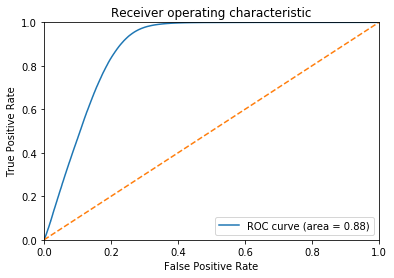

In [69]:
decagon_aurocs_by_se = esp_ddi_util.get_aurocs_by_side_effect(
    negative_examples=negative_examples, positive_examples=positive_examples, negative_results=neg_scores, positive_results=pos_scores)

In [70]:
for c in ['auroc', 'auprc', 'ap50']:
    print(c)
    print('min:', side_effect_names[decagon_aurocs_by_se[c].idxmin()], round(decagon_aurocs_by_se[c].min(
    ), 3), 'max:', side_effect_names[decagon_aurocs_by_se[c].idxmax()], round(decagon_aurocs_by_se[c].max(), 3))
    print()

auroc
min: HYPERMETROPIA 0.259 max: GASTRIC_ULCER_PERFORATED 0.949

auprc
min: HYPERMETROPIA 0.366 max: GALACTORRHEA 0.934

ap50
min: HYPERMETROPIA 0.066 max: SYNCOPE_VASOVAGAL 0.95



### Performance distribution

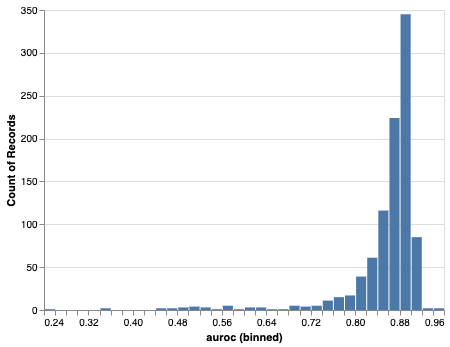

In [72]:
alt.Chart(decagon_aurocs_by_se).mark_bar().encode(
    x=alt.X(
        'auroc', 
        bin=alt.Bin(maxbins=50)
    ), 
    y='count()', 
    tooltip=[
        alt.Tooltip('count()')
    ]
)

### Performance by side effect frequency

In [73]:
df = decagon_aurocs_by_se.reset_index()
df.predicate_name = df.predicate_name.astype(
    'category').cat.rename_categories(side_effect_names)
df.head()
decagon_aurocs_by_se = df.set_index('predicate_name')

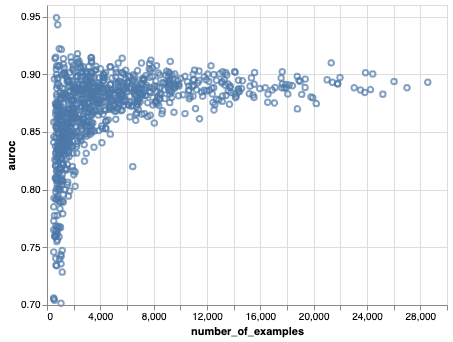

In [74]:
# the positive testing examples constitute 10% of the total number of samples in the dataset
alt.Chart(
    decagon_aurocs_by_se.reset_index()
).mark_point().encode(
    alt.Y(
        'auroc',
        scale=alt.Scale(zero=False)
    ),
    x='number_of_examples:Q',
    tooltip=['predicate_name', 'number_of_examples:Q']
).transform_calculate(
    number_of_examples=alt.datum.positive_examples*10
).transform_filter(alt.datum.auroc>0.7)

This chart shows that Decagon performs generally well on frequent side effects, while rarer side effects vary widely in performance, with some as low as 0.3.

### Score distribution by label

In [75]:
pos_scores['truth'] = 1
neg_scores['truth'] = 0
scores = pos_scores.append(neg_scores)
scores.columns = ['score', 'truth']
scores.head()

/home/haalbu/anaconda3/envs/test_2019-08-28/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/haalbu/anaconda3/envs/test_2019-08-28/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,score,truth
0,0.860732,1
1,0.625638,1
2,0.691289,1
3,0.589250,1
4,0.268906,1


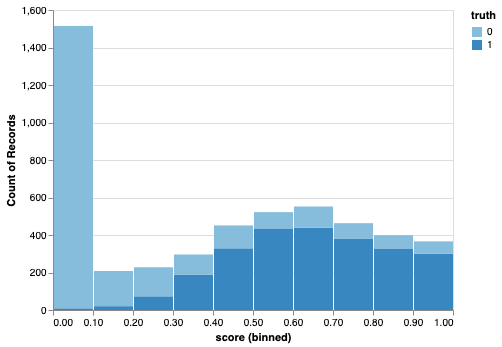

In [76]:
alt.Chart(scores.sample(5000)).mark_bar().encode(
    x=alt.X("score", bin=True), 
    y='count()', 
    color='truth:O'
)

Here we can see that Decagon gives a large portion of the negatives very low scores (<0.1)!

# Comparison of best and worst side effects between ESP and Decagon

In [77]:
print("Best ESP side effects:")
pd.DataFrame(esp_aurocs_by_se[['auprc']].sort_values(
    by="auprc", ascending=False).auprc.apply(lambda x: ("%.3f" % x))).head(5)

Best ESP side effects:


,auprc
predicate_name,
MUMPS,0.966
DYSHIDROSIS,0.963
SARCOMA,0.959
ANAEMIA_HYPOCHROMIC,0.959
SCLC,0.958


In [78]:
print("Worst ESP side effects:")
pd.DataFrame(esp_aurocs_by_se[['auprc']].sort_values(by="auprc",ascending=True).auprc.apply(lambda x: ("%.3f"%x))).head(5)

Worst ESP side effects:


,auprc
predicate_name,
CAESAREAN_SECTION,0.767
MOUTH_BLEEDING,0.771
BRONCHIOLITIS,0.775
EMESIS,0.780
INTERSTITIAL_NEPHRITIS,0.782


Compare to Decagon's reported best and worst side effects

In [79]:
decagon_reported = pd.DataFrame({"MUMPS" : 0.964,
"BLEEDING" : 0.679,
"CARBUNCLE" : 0.949,
"BODY_TEMPERATURE_INCREASED" : 0.680,
"COCCYDYNIA" : 0.943,
"EMESIS" : 0.693,
"TYMPANIC_MEMBRANE_PERFORATION" : 0.941,
"DISORDER_RENAL" : 0.694,
"DYSHIDROSIS" : 0.938,
"LEUCOPENIA" : 0.695,
"SPONDYLOSIS" : 0.929,
"DIARRHEA" : 0.705,
"SCHIZOAFFECTIVE_DISORDER" : 0.919,
"ICTERUS" : 0.707,
"BREAST_DYSPLASIA" : 0.918,
"NAUSEA" : 0.711,
"GANGLION" : 0.909,
"ITCH" : 0.712,
"UTERINE_POLYP" : 0.908,
"ANAEMIA" : 0.712}, index=['decagon_reported_auprc']).transpose()
decagon_reported.head()

,decagon_reported_auprc
MUMPS,0.964
BLEEDING,0.679
CARBUNCLE,0.949
BODY_TEMPERATURE_INCREASED,0.680
COCCYDYNIA,0.943


In [80]:
best_and_worst = decagon_reported.merge(esp_aurocs_by_se.auprc.rename(
    'esp_auprc'), how='left', left_index=True, right_index=True)
best_and_worst.sort_values(by='decagon_reported_auprc', ascending=False).round(3)

,decagon_reported_auprc,esp_auprc
MUMPS,0.964,0.966
CARBUNCLE,0.949,0.931
COCCYDYNIA,0.943,0.938
TYMPANIC_MEMBRANE_PERFORATION,0.941,0.925
DYSHIDROSIS,0.938,0.963
SPONDYLOSIS,0.929,0.932
SCHIZOAFFECTIVE_DISORDER,0.919,0.944
BREAST_DYSPLASIA,0.918,0.900
GANGLION,0.909,0.943
UTERINE_POLYP,0.908,0.895


This chart shows that the best performing side effects for Decagon and ESP are in the similar general region; however, ESP performs much better on side effects that Decagon models poorly.

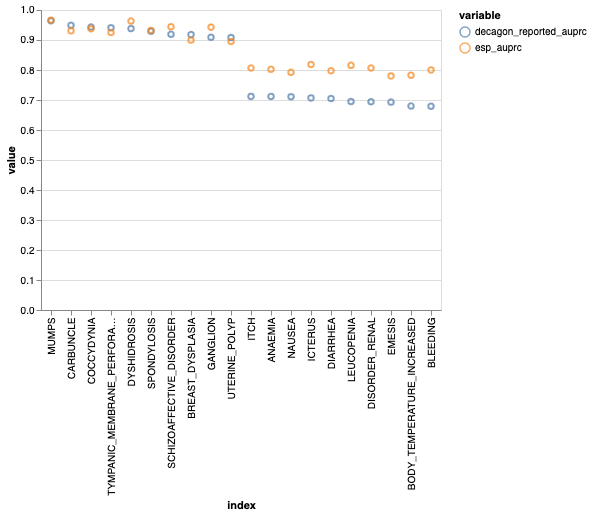

In [81]:
alt.Chart(
    best_and_worst.reset_index().melt(id_vars='index')
).mark_point(
).encode(
    x=alt.X('index', sort=decagon_reported.sort_values(
        by='decagon_reported_auprc', ascending=False).index.tolist()),
    y='value',
    color='variable'
)